In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

In [2]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


# Data preprocessing 

In [3]:

MISSING_TOKEN = 'None'

In [4]:

def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [5]:
def write_break_down_columns(old_caption_file, new_caption_file):
    with open(old_caption_file, 'r') as f:
        for line in f:
            # skip title
            if 'image,caption,psum,psum_sq' in line:
                continue

            image_name, text_label,psum,psum_sq = line.split(',')
            text_label = text_label.strip()

            struc_label = Caption(text_label, support_plural=True).get_structured()
            first_object = struc_label['objects'][0]
            mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
            write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{psum},{psum_sq}")


In [17]:
def get_image_class(item):
    for k,v in CLASSES_MAP.items():
        if v == item:
            return k
    return None
    
c1 = get_image_class(('lion', 'rampant','B'))   
c2 = get_image_class(('lion', MISSING_TOKEN, 'B'))   
c1,c2


(6, 8)

In [6]:
def write_class_colum(df, with_class_caption_file):
    for _,line in df.iterrows():
        image_name,charge,mod,color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['psum'],line['psum_sq']
        image_class = get_image_class((charge, mod, color))

        write_line_to_file(with_class_caption_file, f"{image_name},{charge},{mod},{color},{psum},{psum_sq},{image_class}")


In [7]:
data_location =  '../baseline-gen-data/small/'
# data_location =  '/home/space/datasets/COA/generated-data-api-single/'
caption_file = data_location + 'captions-psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'


creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [8]:
write_break_down_columns(caption_file, new_caption_file)

In [9]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,image_0.png,lion,None,A,284055.562500,238163.890625
1,image_1.png,lion,None,A,347488.750000,323990.218750
2,image_2.png,lion,rampant,A,284055.562500,238163.890625
3,image_3.png,lion,rampant,A,347488.750000,323990.218750
4,image_4.png,lion,passt,A,289033.093750,245082.781250
...,...,...,...,...,...,...
146,image_146.png,lion,passt guard,O,244794.031250,183035.484375
147,image_147.png,lion,passt guard,O,275677.281250,222645.234375
148,image_148.png,lion's,head,O,244669.765625,182592.937500
149,image_149.png,lion's,head,O,277891.625000,225355.921875


In [10]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod          color
lion    None         A        6
        passt guard  A        6
lion's  head         O        6
                     B        6
                     A        6
lion    rampant      O        6
                     B        6
                     A        6
        None         B        6
        passt guard  B        6
                     O        6
        passt        O        6
        None         O        6
        passt        B        6
                     A        6
        None         S        5
        passt        V        4
        rampant      S        4
lion's  head         S        4
lion    None         G        4
lion's  head         G        4
lion    rampant      V        4
                     G        4
        None         V        4
        passt        S        4
        passt guard  V        4
                     S        4
        passt        G        4
        passt guard  G        4
lion's  head         V        4
dtype: int64

In [11]:
classes = list(column_values.to_dict().keys())
classes

[('lion', 'None', 'A'),
 ('lion', 'passt guard', 'A'),
 ("lion's", 'head', 'O'),
 ("lion's", 'head', 'B'),
 ("lion's", 'head', 'A'),
 ('lion', 'rampant', 'O'),
 ('lion', 'rampant', 'B'),
 ('lion', 'rampant', 'A'),
 ('lion', 'None', 'B'),
 ('lion', 'passt guard', 'B'),
 ('lion', 'passt guard', 'O'),
 ('lion', 'passt', 'O'),
 ('lion', 'None', 'O'),
 ('lion', 'passt', 'B'),
 ('lion', 'passt', 'A'),
 ('lion', 'None', 'S'),
 ('lion', 'passt', 'V'),
 ('lion', 'rampant', 'S'),
 ("lion's", 'head', 'S'),
 ('lion', 'None', 'G'),
 ("lion's", 'head', 'G'),
 ('lion', 'rampant', 'V'),
 ('lion', 'rampant', 'G'),
 ('lion', 'None', 'V'),
 ('lion', 'passt', 'S'),
 ('lion', 'passt guard', 'V'),
 ('lion', 'passt guard', 'S'),
 ('lion', 'passt', 'G'),
 ('lion', 'passt guard', 'G'),
 ("lion's", 'head', 'V')]

In [12]:
len(classes)

30

In [13]:
type(classes[0])

tuple

In [14]:
np.nan

nan

In [15]:
# Give unique number to each class
CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('lion', 'None', 'A'),
 1: ('lion', 'passt guard', 'A'),
 2: ("lion's", 'head', 'O'),
 3: ("lion's", 'head', 'B'),
 4: ("lion's", 'head', 'A'),
 5: ('lion', 'rampant', 'O'),
 6: ('lion', 'rampant', 'B'),
 7: ('lion', 'rampant', 'A'),
 8: ('lion', 'None', 'B'),
 9: ('lion', 'passt guard', 'B'),
 10: ('lion', 'passt guard', 'O'),
 11: ('lion', 'passt', 'O'),
 12: ('lion', 'None', 'O'),
 13: ('lion', 'passt', 'B'),
 14: ('lion', 'passt', 'A'),
 15: ('lion', 'None', 'S'),
 16: ('lion', 'passt', 'V'),
 17: ('lion', 'rampant', 'S'),
 18: ("lion's", 'head', 'S'),
 19: ('lion', 'None', 'G'),
 20: ("lion's", 'head', 'G'),
 21: ('lion', 'rampant', 'V'),
 22: ('lion', 'rampant', 'G'),
 23: ('lion', 'None', 'V'),
 24: ('lion', 'passt', 'S'),
 25: ('lion', 'passt guard', 'V'),
 26: ('lion', 'passt guard', 'S'),
 27: ('lion', 'passt', 'G'),
 28: ('lion', 'passt guard', 'G'),
 29: ("lion's", 'head', 'V')}

In [16]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [18]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq.txt'
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [19]:
write_class_colum(df, new_with_class_caption_file)
    

In [20]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,image_0.png,lion,None,A,284055.562500,238163.890625,0
1,image_1.png,lion,None,A,347488.750000,323990.218750,0
2,image_2.png,lion,rampant,A,284055.562500,238163.890625,7
3,image_3.png,lion,rampant,A,347488.750000,323990.218750,7
4,image_4.png,lion,passt,A,289033.093750,245082.781250,14
...,...,...,...,...,...,...,...
146,image_146.png,lion,passt guard,O,244794.031250,183035.484375,10
147,image_147.png,lion,passt guard,O,275677.281250,222645.234375,10
148,image_148.png,lion's,head,O,244669.765625,182592.937500,2
149,image_149.png,lion's,head,O,277891.625000,225355.921875,2


In [22]:
train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 90 train images
There are 30 val images
There are 31 test images


,image,charge,mod,color,psum,psum_sq,class
0,image_57.png,lion,passt guard,V,298968.062500,263112.750000,25
1,image_135.png,lion,passt,B,261956.968750,205849.343750,13
2,image_52.png,lion,rampant,V,237945.031250,180285.078125,21
3,image_21.png,lion,None,O,329076.968750,298626.875000,12
4,image_89.png,lion's,head,O,230054.343750,164018.406250,2
5,image_119.png,lion's,head,V,185696.125000,111316.531250,29
6,image_22.png,lion,rampant,O,265643.875000,212800.562500,5
7,image_83.png,lion,rampant,O,215140.453125,145611.859375,5
8,image_63.png,lion,rampant,A,233552.734375,170973.906250,7
9,image_16.png,lion,passt guard,B,248028.968750,191604.343750,9


# Dataset and Dataloader  

In [23]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [128]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")
#         print(img)
        # apply the transfromation to the image
        if self.transform is not None:
#             print('self.transform is not None')
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)
#         print('img_t: ',img_t)

        return img_t

    def _get_label_class(self, idx):
        
        label_class = self.classes[idx]
#         if self.transform is not None:
#             label_class_t = self.transform(label_class)
#         else:
#             trans = T.ToTensor()
#             label_class_t = trans(label_class)

        return label_class

    



In [73]:
BATCH_SIZE = 56
# NUM_WORKER = 2 #### this needs multi-core
NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [177]:
images_location = data_location + '/res_images'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [178]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(56, 0)), tensor([], size=(56, 0)))

In [179]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [180]:
std = get_std(train_dataset, train_data_loader, mean, 500 , 500)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


In [181]:
mean, std

(tensor(0.3240, dtype=torch.float64), tensor(0.3782, dtype=torch.float64))

# Dataset and Dataloader  

In [182]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [80]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=../baseline-gen-data/small//res_images, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.32401979375, std=0.37820440671442135)
 ), device=cpu, df=            image  charge          mod color           psum        psum_sq  \
 0   image_105.png    lion        passt     G  191927.140625  118235.531250   
 1    image_66.png    lion  passt guard     A  236740.296875  174789.687500   
 2    image_56.png    lion  passt guard     V  240204.171875  183891.906250   
 3     image_6.png    lion  passt guard     A  289546.375000  245690.687500   
 4   image_120.png    lion         None     A  260101.359375  204440.265625   
 ..            ...     ...          ...   ...            ...            ...   
 85   image_72.png    lion      rampant     B  194746.515625  120326.734375   
 86   image_95.png    lion        passt     S  176911.89

In [81]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

In [82]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           ...,
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567]],
 
          [[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           ...,
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567]],
 
          [[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-

In [83]:

dataiter = iter(val_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           ...,
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567]],
 
          [[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           ...,
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567]],
 
          [[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-

In [84]:

dataiter = iter(test_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           ...,
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567]],
 
          [[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           ...,
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567]],
 
          [[-0.8567, -0.8567, -0.8567,  ..., -0.8567, -0.8567, -0.8567],
           [-

In [166]:
def visualize_one_batch(data_loader):
    # Visualize one training batch
    for images,classes,_,_,_ in data_loader:
        print(type(classes))
        fig, ax = plt.subplots(figsize = (25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 5).permute(1,2,0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


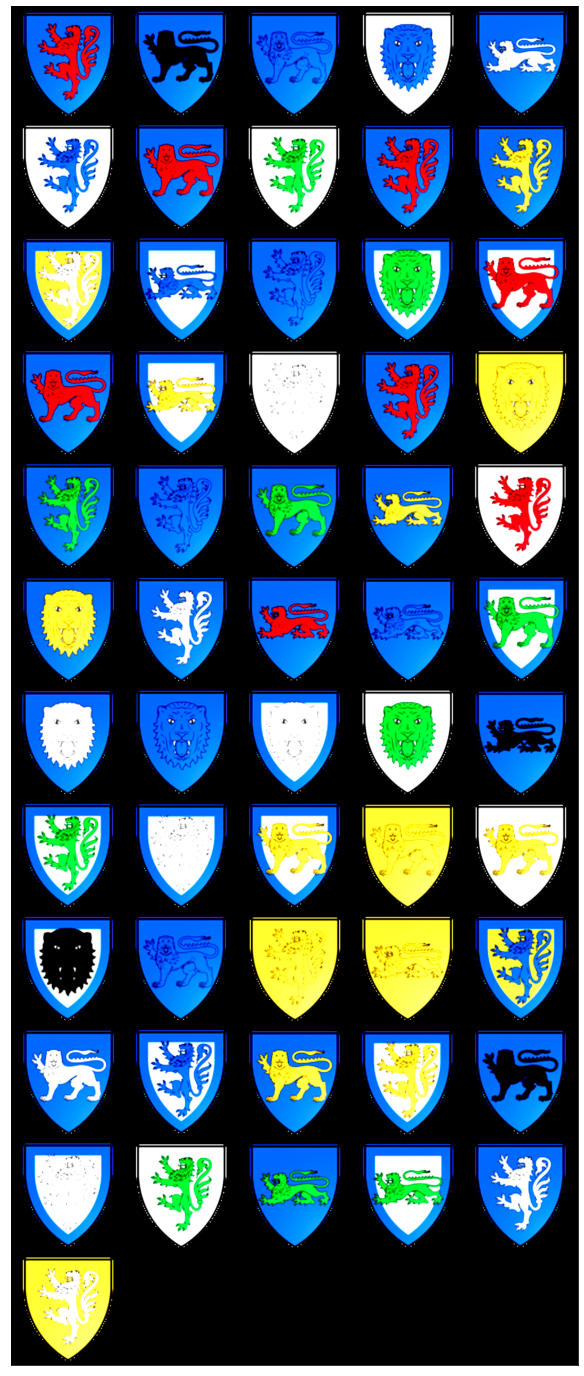

In [167]:

visualize_one_batch(train_data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


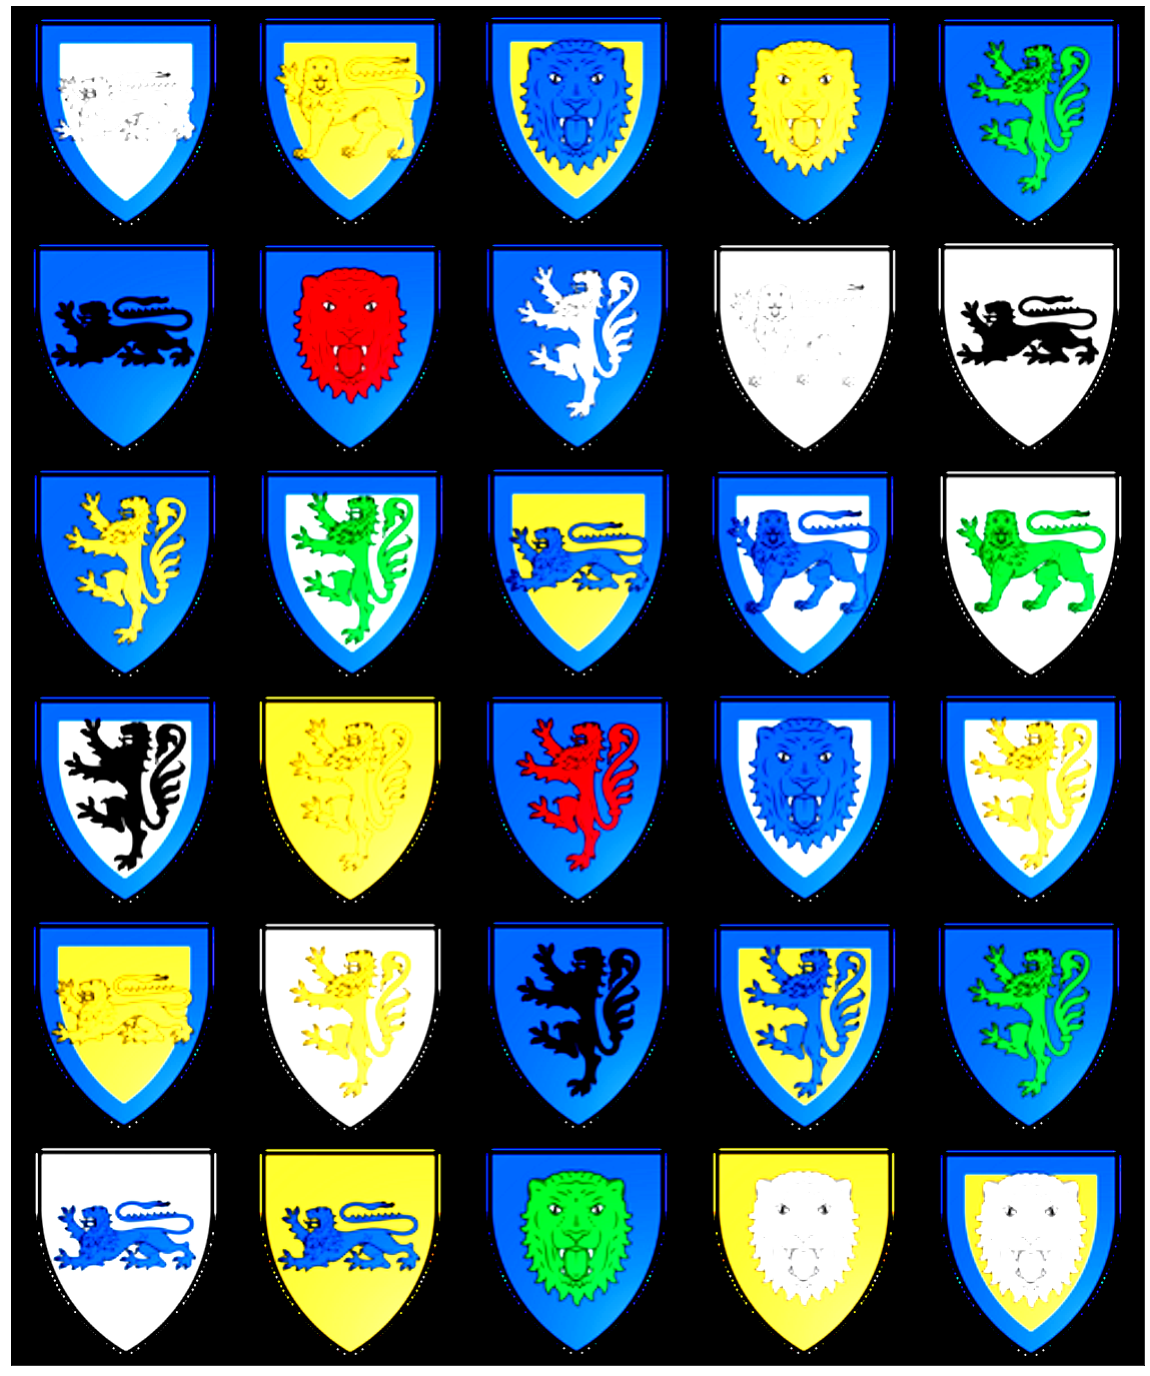

In [87]:
visualize_one_batch(val_data_loader)

# Model Definition

In [88]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


# Model Training, Validation and Testing

In [89]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 5


In [90]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [91]:
### Training Code
from tqdm import tqdm

for epoch in range(epochs):
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    with tqdm(train_data_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels,_,_,_ in tepoch: 
            images = images.to(device)
            labels = labels.to(device)

            #Reset Grads
            optimizer.zero_grad()

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss & Backward, Update Weights (Step)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            #Append loss & acc
            loss_value = loss.item()
            train_epoch_loss.append(loss_value)
            train_epoch_accuracy.append(acc)
            
            tepoch.set_postfix({'train_epoch_loss': loss_value})
#             tepoch.set_postfix({'train_epoch_accuracy',acc})

            if _iter % 500 == 0:
                print("> Iteration {} < ".format(_iter))
                print("Iter Loss = {}".format(round(loss_value, 4)))
                print("Iter Accuracy = {} % \n".format(acc))

#             _iter += 1

    #Validation
    with tqdm(val_data_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels,_,_,_ in tepoch:
            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
            val_epoch_accuracy.append(acc)
            tepoch.set_postfix({'val_epoch_loss': loss_value})
#             tepoch.set_postfix({'val_epoch_accuracy',acc})

    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.98s/batch, val_epoch_loss=4.55]


** Epoch 0 ** - Epoch Time 267
Train Loss = 5.1982
Train Accuracy = 6.7752 % 

Val Loss = 4.5523
Val Accuracy = 0.0 % 



Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.62s/batch, val_epoch_loss=4.42]


** Epoch 1 ** - Epoch Time 267
Train Loss = 4.0322
Train Accuracy = 10.08405 % 

Val Loss = 4.4191
Val Accuracy = 3.3333 % 



Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.49s/batch, val_epoch_loss=3.26]


** Epoch 2 ** - Epoch Time 265
Train Loss = 2.8789
Train Accuracy = 21.90125 % 

Val Loss = 3.2563
Val Accuracy = 13.3333 % 



Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.14s/batch, val_epoch_loss=2.58]


** Epoch 3 ** - Epoch Time 260
Train Loss = 2.0651
Train Accuracy = 40.7563 % 

Val Loss = 2.5763
Val Accuracy = 33.3333 % 



Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.18s/batch, val_epoch_loss=2.73]

** Epoch 4 ** - Epoch Time 260
Train Loss = 1.5647
Train Accuracy = 60.34665 % 

Val Loss = 2.728
Val Accuracy = 23.3333 % 



## Save model to disk

In [47]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [56]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [153]:
def test_classification_model(model, test_data_loader):
    test_epoch_loss = []
    test_epoch_accuracy = []

    test_loss = []
    test_accuracy = []

    # model.eval()
    with torch.no_grad():
        for images, labels,_,_,_ in test_data_loader:
            print(type(labels))
            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            test_epoch_loss.append(loss_value)
            test_epoch_accuracy.append(acc)

    test_epoch_loss = np.mean(test_epoch_loss)
    test_epoch_accuracy = np.mean(test_epoch_accuracy)

    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print("Test Loss = {}".format(round(test_epoch_loss, 4)))
    print("Test Accuracy = {} % \n".format(test_epoch_accuracy))



In [154]:
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
Test Loss = 2.3457
Test Accuracy = 25.8065 % 



## Test pretrained model on real data


In [155]:
real_data_location =  '/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out/'
# real_data_location =  '/home/salnabulsi/coat-of-arms/data/cropped_coas/out/'
# real_caption_file = real_data_location + 'test_real_captions_psumsq.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq.txt'
# new_real_with_class_caption_file = real_data_location + 'new-test-real-labels-with-class-psumsq.txt'


real_caption_file = real_data_location + 'real_captions_psumsq_lions_cleaned.txt'
new_real_caption_file = real_data_location + '/real_labels_psumsq_lions_cleaned.txt'
new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_lions_cleaned.txt'


In [156]:
creat_caption_file(new_real_caption_file, 'image,charge,mod,color,psum,psum_sq')
write_break_down_columns(real_caption_file, new_real_caption_file)
df = pd.read_csv(new_real_caption_file).fillna(MISSING_TOKEN)
df            

,image,charge,mod,color,psum,psum_sq
0,2870_O S lion rampant.jpg,lion,rampant,S,3.702197e+05,2.310431e+05
1,17931_O B lion rampant.jpg,lion,rampant,B,6.178990e+05,4.476455e+05
2,1543_G O lion passt guard.jpg,lion,passt guard,O,7.022976e+05,5.054572e+05
3,1154_A G lion rampant.jpg,lion,rampant,G,8.061751e+05,6.128734e+05
4,2540_B A lion rampant.jpg,lion,rampant,A,6.654623e+05,4.692596e+05
...,...,...,...,...,...,...
111,17945_A G 3 lions.jpg,lions,None,G,8.183659e+05,6.400101e+05
112,18220_A S lion rampant.jpg,lion,rampant,S,3.330191e+06,2.296496e+06
113,398_A S lion rampant.jpg,lion,rampant,S,6.734806e+05,5.176513e+05
114,249_O G 2 lions passt.jpg,lions,passt,G,8.710461e+05,6.773581e+05


In [ ]:
creat_caption_file(new_real_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')
write_class_colum(df, new_real_with_class_caption_file)


In [188]:
df_new = pd.read_csv(new_real_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,2870_O S lion rampant.jpg,lion,rampant,S,3.702197e+05,2.310431e+05,17
1,17931_O B lion rampant.jpg,lion,rampant,B,6.178990e+05,4.476455e+05,6
2,1543_G O lion passt guard.jpg,lion,passt guard,O,7.022976e+05,5.054572e+05,10
3,1154_A G lion rampant.jpg,lion,rampant,G,8.061751e+05,6.128734e+05,22
4,2540_B A lion rampant.jpg,lion,rampant,A,6.654623e+05,4.692596e+05,7
...,...,...,...,...,...,...,...
74,17947_G O lion rampant.jpg,lion,rampant,O,6.789981e+05,5.186399e+05,5
75,22627_G O lion rampant.jpg,lion,rampant,O,6.082312e+05,4.344729e+05,5
76,22050_B A lion rampant.jpg,lion,rampant,A,8.087534e+05,5.757471e+05,7
77,18220_A S lion rampant.jpg,lion,rampant,S,3.330191e+06,2.296496e+06,17


In [189]:
real_images_location = real_data_location + '/resized'

# essentila for calc mean
real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)

In [190]:
# r_mean = get_mean(real_test_dataset, real_test_data_loader, 500 , 500)
# r_std = get_std(real_test_dataset, real_test_data_loader, r_mean, 500 , 500)

# r_mean,r_std 


In [191]:


real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

real_test_random_sampler = RandomSampler(real_test_dataset)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = real_test_random_sampler,
    num_workers = NUM_WORKER,
)


In [192]:
dataiter = iter(real_test_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[ 1.5903,  1.5800,  1.5903,  ...,  1.5074,  1.5177,  1.5177],
           [ 1.6007,  1.5903,  1.6007,  ...,  1.5177,  1.5281,  1.5281],
           [ 1.6111,  1.6007,  1.6111,  ...,  1.5385,  1.5489,  1.5489],
           ...,
           [ 1.6111,  1.6007,  1.6214,  ...,  1.5592,  1.5592,  1.5592],
           [ 1.6111,  1.6007,  1.6214,  ...,  1.5696,  1.5592,  1.5592],
           [ 1.6111,  1.6007,  1.6214,  ...,  1.5696,  1.5592,  1.5592]],
 
          [[ 1.4659,  1.4555,  1.4555,  ...,  1.3726,  1.3622,  1.3622],
           [ 1.4763,  1.4659,  1.4659,  ...,  1.3830,  1.3726,  1.3726],
           [ 1.4866,  1.4763,  1.4763,  ...,  1.3830,  1.3933,  1.3933],
           ...,
           [ 1.4348,  1.4244,  1.4452,  ...,  1.4037,  1.4037,  1.4037],
           [ 1.4348,  1.4244,  1.4452,  ...,  1.4141,  1.4037,  1.4037],
           [ 1.4348,  1.4244,  1.4452,  ...,  1.4141,  1.4037,  1.4037]],
 
          [[ 1.2378,  1.2274,  1.2274,  ...,  1.1652,  1.1445,  1.1445],
           [ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


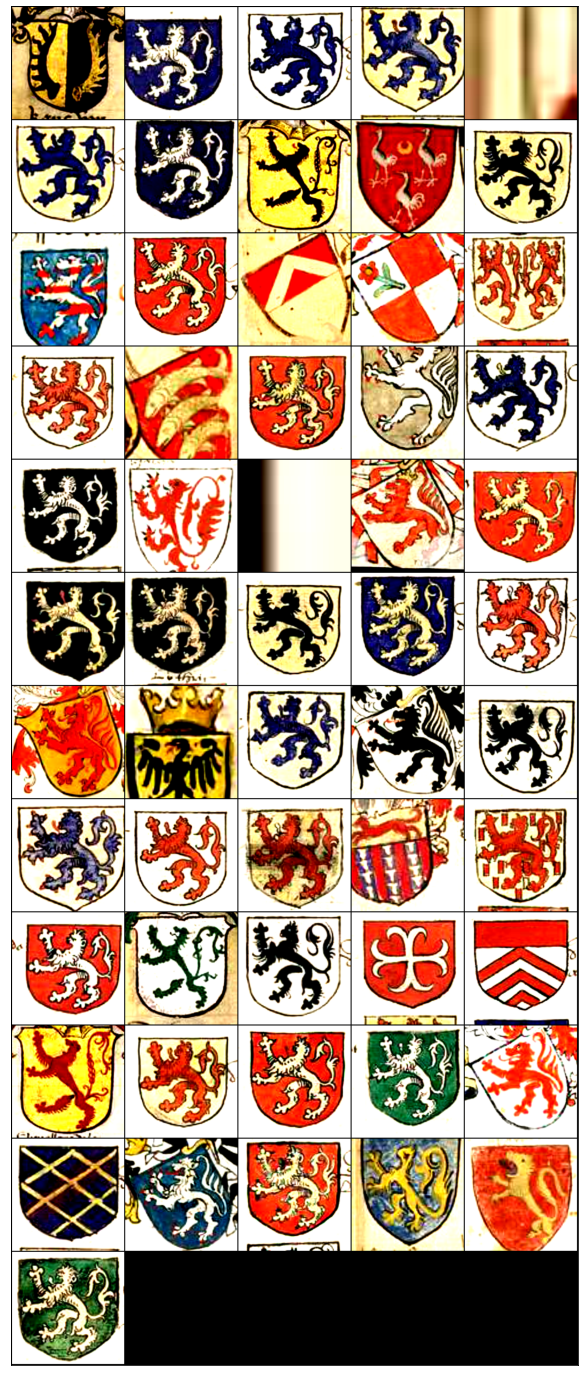

In [193]:

visualize_one_batch(real_test_data_loader)


In [194]:
test_epoch_loss = []
test_epoch_accuracy = []

test_loss = []
test_accuracy = []

# model.eval()
with torch.no_grad():
    for images, labels,_,_,_ in real_test_data_loader:
        # notice that having one "None" as class values change the type of labels into tuple
        # which doesn't have to() function. Hence, I cleaned them up manually for now for testing
        # TODO: find a solution for this usecase
        images = images.to(device)
        labels = labels.to(device)

        #Forward ->
        preds = model(images)

        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())

        #Calculate Loss
        loss = criterion(preds, labels)

        #Append loss & acc
        loss_value = loss.item()
        test_epoch_loss.append(loss_value)
        test_epoch_accuracy.append(acc)

test_epoch_loss = np.mean(test_epoch_loss)
test_epoch_accuracy = np.mean(test_epoch_accuracy)

test_loss.append(test_epoch_loss)
test_accuracy.append(test_epoch_accuracy)

print("Test Loss = {}".format(round(test_epoch_loss, 4)))
print("Test Accuracy = {} % \n".format(test_epoch_accuracy))



Test Loss = 3.7078
Test Accuracy = 5.2407 % 

